In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [7]:
# Load Data and Preprocess
def load_data(path="/content/bank-full.csv", scale=True, drop_target=True, target_col="y"):
    df = pd.read_csv(path, sep=';')
    df.columns = [c.lower().strip() for c in df.columns]

    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].str.strip()

    if drop_target and (target_col in df.columns):
        feature_df = df.drop(columns=[target_col])
    else:
        feature_df = df.copy()

    cat_cols = feature_df.select_dtypes(include="object").columns
    if len(cat_cols) > 0:
        feature_df = pd.get_dummies(feature_df, columns=cat_cols, drop_first=True)

    if scale:
        scaler = StandardScaler()
        feature_df = pd.DataFrame(
            scaler.fit_transform(feature_df),
            columns=feature_df.columns,
            index=feature_df.index
        )

    return feature_df.values, df


# ==================== PCA =======================
def apply_pca(x, n_components=2, return_model=False):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(x)

    if return_model:
        return reduced, pca
    return reduced


# ==================== K-Means ====================
def find_optimal_clusters(x, max_clusters=10, plot=True):
    ks = list(range(1, max_clusters + 1))
    inertias = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=10)
        km.fit(x)
        inertias.append(km.inertia_)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(ks, inertias, marker='o')
        plt.xlabel("Clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow Method")
        plt.grid(alpha=0.3)
        plt.show()

    return {"ks": ks, "inertias": inertias}


def perform_kmeans_clustering(x, n_clusters=3, return_model=False):
    km = KMeans(n_clusters=n_clusters, n_init=10)
    labels = km.fit_predict(x)

    if return_model:
        return labels, km
    return labels


# ==================== Agglomerative ===============
def perform_agglomerative_clustering(x, n_clusters=3, linkage_method="ward", affinity=None, return_model=False):
    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage_method,
        affinity=affinity
    )
    labels = model.fit_predict(x)

    if return_model:
        return labels, model
    return labels


# ==================== Dendrogram ==================
def get_linkages(x, method="ward", metric="euclidean"):
    return linkage(x, method=method, metric=metric)


def plot_dendrogram(linked, truncate_mode=None, p=30):
    plt.figure(figsize=(10, 6))
    dendrogram(linked, truncate_mode=truncate_mode, p=p)
    plt.xlabel("Samples / Clusters")
    plt.ylabel("Distance")
    plt.title("Dendrogram")
    plt.tight_layout()
    plt.show()


## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [16]:
import pandas as pd

def load_data(path="/content/bank-full.csv"):
    """
    Load and preprocess the bank marketing dataset.

    Steps:
    1. Load the CSV file (semicolon-separated)
    2. Label-encode categorical columns
    3. Scale selected numerical + encoded features
    """

    # Load data (your file needed quotechar + on_bad_lines)
    df = pd.read_csv(
        path,
        sep=';',
        quotechar='"',
        on_bad_lines='skip',
        engine='python'
    )

    # Columns to label-encode
    categorical_cols = [
        'job', 'marital', 'education', 'default', 'housing',
        'loan', 'contact', 'month', 'poutcome', 'y'
    ]

    # Apply LabelEncoder to each categorical column
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    # Feature selection for clustering
    features = [
        'age', 'balance', 'campaign', 'previous',
        'job', 'education', 'housing', 'loan', 'default'
    ]

    X = df[features]

    # Drop rows with NaN values before scaling
    X = X.dropna()

    # Scale the features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

X_scaled, data = load_data("/content/bank-full.csv")
print("Data shape:", X_scaled.shape)


Data shape: (45211, 9)


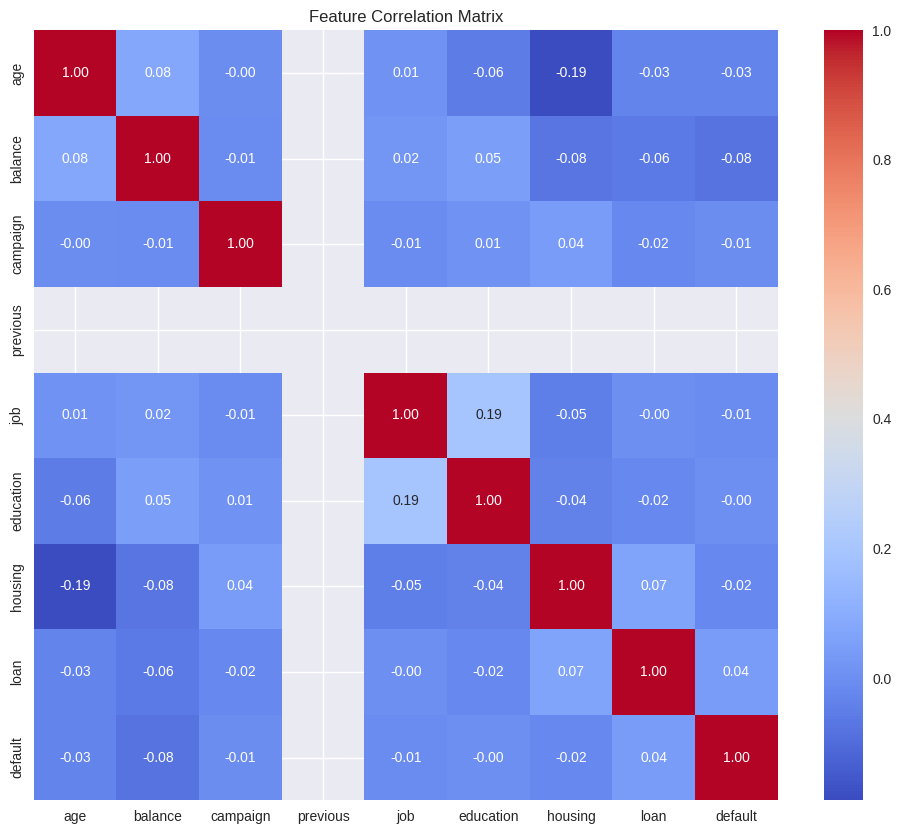

In [12]:
class KMeansClustering:
    """Minimal, student-friendly K-means implementation.

    Core methods implemented:
      - _initialize_centroids: pick k distinct samples
      - _assign_clusters: nearest-centroid assignment (Euclidean)
      - _update_centroids: mean of assigned points (reinit empty clusters)
      - fit: loop until convergence or max_iters
      - predict: assign labels given fitted centroids

    Attributes after fit:
      - centroids: array (n_clusters, n_features)
      - labels: array (n_samples,)
      - inertia_: float (sum of squared distances to centroids)
    """

    def __init__(self, n_clusters=3, max_iters=100, random_state=42, tol=1e-6):
        self.n_clusters = int(n_clusters)
        self.max_iters = int(max_iters)
        self.random_state = int(random_state)
        self.tol = float(tol)

        self.centroids = None
        self.labels = None
        self.inertia_ = None

    def _initialize_centroids(self, X):
        """Randomly pick `n_clusters` distinct rows from X as initial centroids."""
        rng = np.random.RandomState(self.random_state)
        indices = rng.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices].astype(float)

    def _assign_clusters(self, X):
        """Return nearest-centroid labels for each row in X (Euclidean)."""
        # distances shape: (n_samples, n_clusters)
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Compute new centroids as cluster means. If cluster empty, reinitialize to a random sample."""
        rng = np.random.RandomState(self.random_state)
        new_centroids = np.zeros_like(self.centroids, dtype=float)

        for k in range(self.n_clusters):
            members = X[labels == k]
            if members.shape[0] == 0:
                # Reinitialize empty centroid to a random sample from X
                new_centroids[k] = X[rng.randint(0, X.shape[0])]
            else:
                new_centroids[k] = members.mean(axis=0)

        return new_centroids

    def _compute_inertia(self, X, labels, centroids):
        """Sum of squared distances of samples to their closest centroid."""
        d = np.linalg.norm(X - centroids[labels], axis=1)
        return float((d ** 2).sum())

    def fit(self, X):
        """Fit K-means on X. Stores centroids, labels and inertia_. Returns self."""
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array-like of shape (n_samples, n_features).")

        self.centroids = self._initialize_centroids(X)
        prev_centroids = None

        for i in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)

            # check convergence
            if prev_centroids is not None and np.allclose(prev_centroids, new_centroids, atol=self.tol):
                self.centroids = new_centroids
                self.labels = labels
                break

            prev_centroids = self.centroids
            self.centroids = new_centroids
            self.labels = labels
        else:
            # loop completed without break; ensure labels set
            self.labels = self._assign_clusters(X)

        # final inertia
        self.inertia_ = self._compute_inertia(X, self.labels, self.centroids)
        return self

    def predict(self, X):
        """Assign each sample in X to the nearest centroid. Requires fit() first."""
        if self.centroids is None:
            raise ValueError("Model not fitted yet. Call fit(X) before predict().")
        X = np.asarray(X, dtype=float)
        return self._assign_clusters(X)

features = ['age', 'balance', 'campaign', 'previous', 'job',
            'education', 'housing', 'loan', 'default']

# Create correlation matrix only for these 9 features
corr = pd.DataFrame(X_scaled, columns=features).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

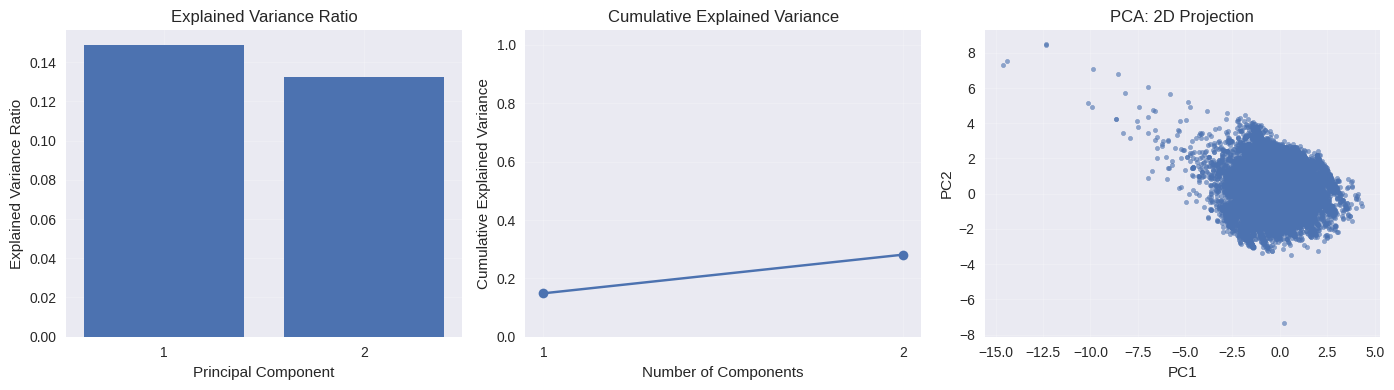

In [18]:
def apply_pca(X, n_components=2, return_model=False):
    """
    Apply PCA for dimensionality reduction and show helpful plots.

    - X: array-like shape (n_samples, n_features)
    - n_components: int (number of components to keep)
    - return_model: if True, returns (X_pca, pca) else returns X_pca

    Plots:
    1) Explained variance ratio (bar)
    2) Cumulative explained variance (line)
    3) 2D scatter of first two principal components (if available)
    """
    X = np.asarray(X, dtype=float)
    n_samples, n_features = X.shape

    # validate n_components
    if not isinstance(n_components, int) or n_components < 1:
        raise ValueError("n_components must be a positive integer.")
    max_possible = min(n_samples, n_features)
    if n_components > max_possible:
        raise ValueError(f"n_components cannot exceed min(n_samples, n_features)={max_possible}.")

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # --- plotting ---
    # choose layout depending on whether 2D scatter is possible
    n_plots = 3 if n_components >= 2 else 2
    plt.figure(figsize=(14, 4))

    # Explained Variance Ratio (bar)
    plt.subplot(1, n_plots, 1)
    pcs = np.arange(1, n_components + 1)
    plt.bar(pcs, pca.explained_variance_ratio_)
    plt.xticks(pcs)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance Ratio")
    plt.grid(alpha=0.2)

    # Cumulative Explained Variance (line)
    plt.subplot(1, n_plots, 2)
    plt.plot(pcs, np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xticks(pcs)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.2)

    # 2D scatter (first two PCs)
    if n_components >= 2:
        plt.subplot(1, n_plots, 3)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PCA: 2D Projection")
        plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    if return_model:
        return X_pca, pca
    return X_pca
X_pca = apply_pca(X_scaled, n_components=2)


## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

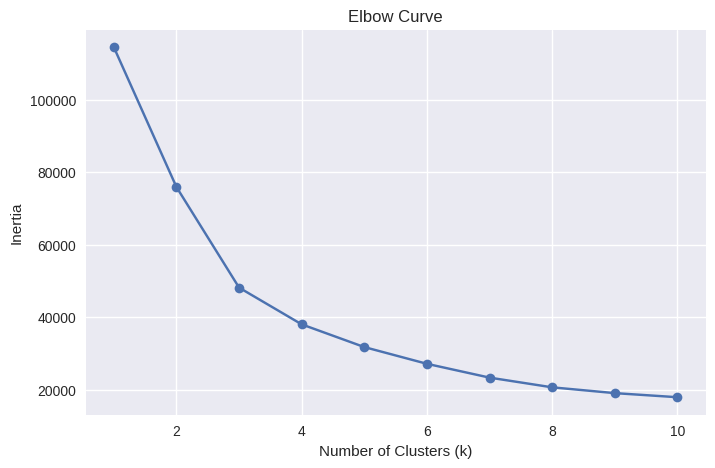

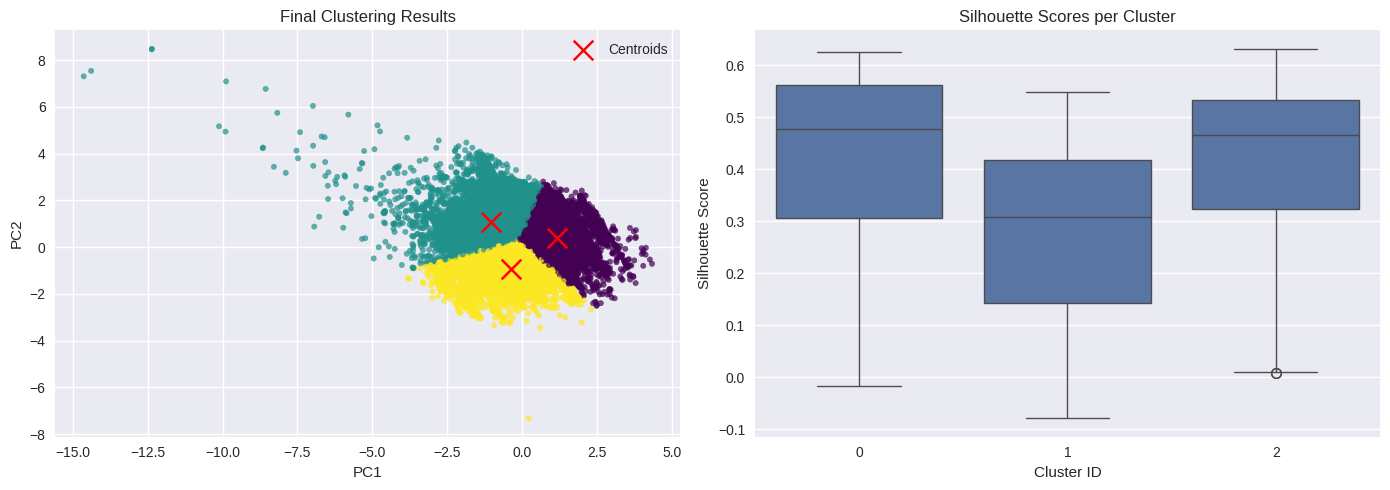

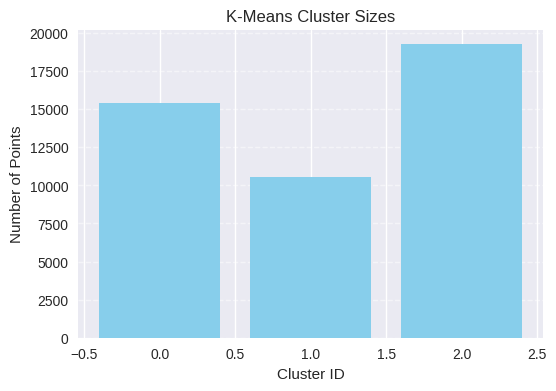


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score (mean of samples): 0.39


In [22]:
from sklearn.metrics import silhouette_samples

def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0.0
    for k in range(centroids.shape[0]):
        cluster_points = X[labels == k]
        if cluster_points.shape[0] > 0:
            distances = np.linalg.norm(cluster_points - centroids[k], axis=1)
            inertia += np.sum(distances ** 2)
    return inertia


def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters."""
    inertias = []
    Ks = range(1, max_k + 1)

    for k in Ks:
        model = KMeansClustering(n_clusters=k)
        model.fit(X)
        inertia_k = calculate_inertia(X, model.labels, model.centroids)
        inertias.append(inertia_k)

    plt.figure(figsize=(8, 5))
    plt.plot(list(Ks), inertias, marker='o')
    plt.title("Elbow Curve")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    return inertias


# -------------------------
# Run elbow to inspect inertias
# -------------------------
inertias = plot_elbow_curve(X_pca, max_k=10)

# -------------------------
# Final clustering (choose k from elbow)
# -------------------------
k_final = 3
kmeans = KMeansClustering(n_clusters=k_final)
kmeans.fit(X_pca)

# -------------------------
# Visualize final results
# -------------------------
plt.figure(figsize=(14, 5))

# Cluster scatter + centroids
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', s=15, alpha=0.7)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Silhouette boxplot per cluster (only if silhouette can be computed)
plt.subplot(1, 2, 2)
try:
    # silhouette_samples requires at least 2 clusters and < n_samples clusters
    if len(np.unique(kmeans.labels)) > 1:
        sil_samples = silhouette_samples(X_pca, kmeans.labels)
        sns.boxplot(x=kmeans.labels, y=sil_samples)
        plt.title("Silhouette Scores per Cluster")
        plt.xlabel("Cluster ID")
        plt.ylabel("Silhouette Score")
    else:
        plt.text(0.5, 0.5, "Silhouette not available for 1 cluster", ha='center', va='center')
        plt.axis('off')
except Exception as e:
    plt.text(0.5, 0.5, f"Silhouette error: {e}", ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

# -------------------------
# K-Means Cluster Size Bar Plot
# -------------------------
unique_ids, counts = np.unique(kmeans.labels, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(unique_ids, counts, color='skyblue')
plt.title("K-Means Cluster Sizes")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Points")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# -------------------------
# Compute and print evaluation metrics
# -------------------------
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)

# If silhouette_samples exists use its mean as silhouette score, else mark as None
silhouette = None
if len(np.unique(kmeans.labels)) > 1:
    try:
        sil = silhouette_samples(X_pca, kmeans.labels)
        silhouette = float(np.mean(sil))
    except Exception:
        silhouette = None

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
if silhouette is not None:
    print(f"Silhouette Score (mean of samples): {silhouette:.2f}")
else:
    print("Silhouette Score: N/A (could not compute)")


## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

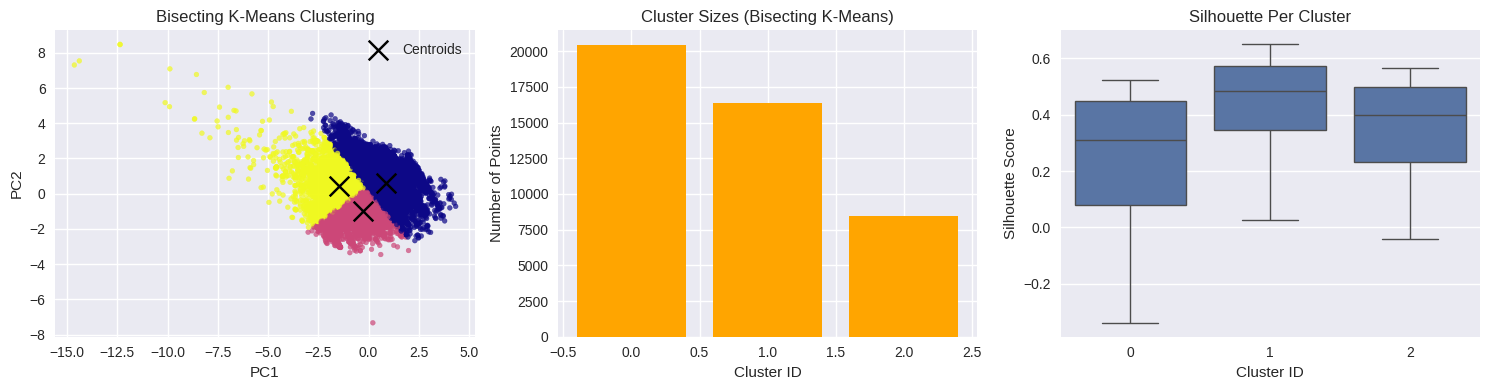


Bisecting K-Means Evaluation:
Silhouette Score (mean of samples): 0.33789411031538313


In [21]:
class BisectingKMeans:
    """
    Bisecting K-Means (concise, student-friendly).

    Algorithm:
      - Start with all points in cluster 0
      - Repeatedly pick the largest cluster (with size > 1) and bisect it using KMeans(k=2)
      - Keep one child with the parent's label; assign a new label id to the other child
      - Stop when desired number of clusters is reached or no cluster can be split
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = int(n_clusters)
        self.random_state = int(random_state)
        self.labels_ = None
        self.split_tree = {}   # parent_label -> (left_label, right_label)
        self.centers_ = {}     # label -> centroid (as np.array)

    def fit_predict(self, X):
        """Fit bisecting k-means and return labels (numpy array)."""
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]

        # Start: all points in cluster 0
        self.labels_ = np.zeros(n_samples, dtype=int)
        next_label = 1

        # Keep splitting until we have desired number of clusters
        while len(np.unique(self.labels_)) < self.n_clusters:
            unique_labels, counts = np.unique(self.labels_, return_counts=True)

            # find largest splittable cluster (size > 1)
            splittable = [(lab, cnt) for lab, cnt in zip(unique_labels, counts) if cnt > 1]
            if not splittable:
                # nothing left to split
                break

            # choose largest cluster by size
            cluster_to_split = max(splittable, key=lambda x: x[1])[0]

            # indices and subset
            idx = np.where(self.labels_ == cluster_to_split)[0]
            X_subset = X[idx]

            # safety: if len <= 1 skip (shouldn't happen due to splittable filter)
            if X_subset.shape[0] <= 1:
                break

            # bisect using sklearn KMeans (k=2)
            km = KMeans(n_clusters=2, random_state=self.random_state, n_init=10)
            sub_labels = km.fit_predict(X_subset)

            # define child labels: keep parent's label for one child, assign new label to other
            left_child = int(cluster_to_split)
            right_child = int(next_label)
            next_label += 1

            # assign back: sub_labels == 0 -> left_child, sub_labels == 1 -> right_child
            self.labels_[idx[sub_labels == 0]] = left_child
            self.labels_[idx[sub_labels == 1]] = right_child

            # record split tree and centroids for children
            self.split_tree[cluster_to_split] = (left_child, right_child)
            # cluster_centers_ array order corresponds to sub_labels values 0 and 1
            self.centers_[left_child] = km.cluster_centers_[0]
            self.centers_[right_child] = km.cluster_centers_[1]

            # If we've created enough labels, break early
            if len(np.unique(self.labels_)) >= self.n_clusters:
                break

        # Ensure every final label has a centroid in centers_ (compute from data if missing)
        final_labels = np.unique(self.labels_)
        for lab in final_labels:
            if lab not in self.centers_:
                members = X[self.labels_ == lab]
                if members.shape[0] > 0:
                    self.centers_[lab] = members.mean(axis=0)
                else:
                    # fallback: random sample (should not normally occur)
                    self.centers_[lab] = X[np.random.randint(0, n_samples)]

        return self.labels_


# ------------------------
# Run Bisecting KMeans & Visualize
# ------------------------
bkmeans = BisectingKMeans(n_clusters=3, random_state=42)
b_labels = bkmeans.fit_predict(X_pca)

# Build centroid array sorted by label id (handles missing keys)
sorted_labels = sorted(np.unique(b_labels).tolist())
b_centroids = np.array([bkmeans.centers_[lab] for lab in sorted_labels])

plt.figure(figsize=(15, 4))

# 1) Scatter with centroids
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=b_labels, cmap='plasma', s=12, alpha=0.7)
plt.scatter(b_centroids[:, 0], b_centroids[:, 1], c='black', marker='x', s=200, label='Centroids')
plt.title("Bisecting K-Means Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# 2) Cluster sizes
plt.subplot(1, 3, 2)
unique, counts = np.unique(b_labels, return_counts=True)
plt.bar(unique, counts, color='orange')
plt.title("Cluster Sizes (Bisecting K-Means)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Points")

# 3) Silhouette distribution per cluster (safe: requires at least 2 clusters)
plt.subplot(1, 3, 3)
if len(np.unique(b_labels)) > 1:
    sil_vals = silhouette_samples(X_pca, b_labels)
    sns.boxplot(x=b_labels, y=sil_vals)
    plt.title("Silhouette Per Cluster")
    plt.xlabel("Cluster ID")
    plt.ylabel("Silhouette Score")
else:
    plt.text(0.5, 0.5, "Silhouette not available for 1 cluster", ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print evaluation (mean silhouette using silhouette_samples)
if len(np.unique(b_labels)) > 1:
    sil_vals = silhouette_samples(X_pca, b_labels)
    print("\nBisecting K-Means Evaluation:")
    print("Silhouette Score (mean of samples):", float(np.mean(sil_vals)))
else:
    print("\nBisecting K-Means Evaluation:")
    print("Silhouette Score: N/A (only one cluster)")


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!